In [1]:
import numpy as np
import pandas as pd
import re
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score, classification_report,confusion_matrix
import os
import matplotlib.pyplot as plt

In [2]:
train_path = 'data/kickstarter_train_final.csv'
test_path = 'data/kickstarter_test_final.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

print(train_df.shape)
print(test_df.shape)

(24756, 579)
(4369, 579)


In [3]:
#features that are dependent on time and the final outcome
X_train, y_train = train_df.drop('state', axis=1), train_df['state']
X_test, y_test = test_df.drop('state', axis=1), test_df['state']

In [4]:
# Combine train and test data set tgt
X = pd.concat([X_train, X_test])
y = pd.concat([y_train, y_test])

In [5]:
# Check if dataset is balanced
print(train_df[train_df.state == 1].shape)
print(train_df[train_df.state == 0].shape)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(17482, 579)
(7274, 579)
(24756, 578)
(24756,)
(4369, 578)
(4369,)


In [9]:
#Default model
model_xgboost_default = XGBClassifier()

model_xgboost_default.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,
                  eval_set=[(X_test, y_test)],
                  verbose=True)

xgb_train_default_predict = model_xgboost_default.predict(X_train)
xgb_test_default_predict = model_xgboost_default.predict(X_test)

c:\Users\bandy\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-logloss:0.51529
[1]	validation_0-logloss:0.41470
[2]	validation_0-logloss:0.34874
[3]	validation_0-logloss:0.30429
[4]	validation_0-logloss:0.27352
[5]	validation_0-logloss:0.25144
[6]	validation_0-logloss:0.23480
[7]	validation_0-logloss:0.22210
[8]	validation_0-logloss:0.21294
[9]	validation_0-logloss:0.20595
[10]	validation_0-logloss:0.19899
[11]	validation_0-logloss:0.19367
[12]	validation_0-logloss:0.18984
[13]	validation_0-logloss:0.18694
[14]	validation_0-logloss:0.18262
[15]	validation_0-logloss:0.18110
[16]	validation_0-logloss:0.17962
[17]	validation_0-logloss:0.17764
[18]	validation_0-logloss:0.17648
[19]	validation_0-logloss:0.17516
[20]	validation_0-logloss:0.17425
[21]	validation_0-logloss:0.17276
[22]	validation_0-logloss:0.17260
[23]	validation_0-logloss:0.17142
[24]	validation_0-logloss:0.17056
[25]	validation_0-logloss:0.16955
[26]	validation_0-logloss:0.16865
[27]	validation_0-logloss:0.16893
[28]	validation_0-logloss:0.16891
[29]	validation_0-loglos

**Evaluate Model Performance**

In [11]:
print(confusion_matrix(y_train, xgb_train_default_predict))
print(classification_report(y_train, xgb_train_default_predict))

[[ 6947   327]
 [   98 17384]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      7274
           1       0.98      0.99      0.99     17482

    accuracy                           0.98     24756
   macro avg       0.98      0.97      0.98     24756
weighted avg       0.98      0.98      0.98     24756



In [12]:
print(confusion_matrix(y_test, xgb_test_default_predict))
print(classification_report(y_test, xgb_test_default_predict))

[[1082  200]
 [  69 3018]]
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      1282
           1       0.94      0.98      0.96      3087

    accuracy                           0.94      4369
   macro avg       0.94      0.91      0.92      4369
weighted avg       0.94      0.94      0.94      4369



In [14]:
model_xgboost_default.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)>

**Hyperparameter Tuning**

We will use GridSearchCV for hyperparameter tuning.


In [6]:
learning_rate_list = [0.1, 0.3, 0.5]
max_depth_list = [2, 3, 5]
n_estimators_list = [50, 100, 150]
subsample_list = [0.3, 0.5, 0.7]
colsample_bytree_list =  [0.3, 0.5, 0.7]


params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list,
               "subsample": subsample_list,
               "colsample_bytree" : colsample_bytree_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) 

print(num_combinations)
params_dict

243


{'learning_rate': [0.1, 0.3, 0.5],
 'max_depth': [2, 3, 5],
 'n_estimators': [50, 100, 150],
 'subsample': [0.3, 0.5, 0.7],
 'colsample_bytree': [0.3, 0.5, 0.7]}

In [7]:
# Custom cross-validation method
cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=2022)

model_xgboost_tuning = RandomizedSearchCV(estimator= XGBClassifier(),
                                param_distributions = params_dict,
                                cv=cv_method,
                                scoring='roc_auc',
                                n_iter = 100,
                                verbose=2,
                                random_state=2022)

model_xgboost_tuning.fit(X, y)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.0s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   2.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.8s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=2, n_estimators=50, subsample=0.3; total time=   3.8s
[CV] END colsample_bytr

RandomizedSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=2022),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=No...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=100,
                   param_distributions={'colsample_bytree': [0.3, 0.5, 0.7],
                                        'learning_rate': [0.1, 0.3, 0.5],
                                        'max_depth': [2, 3, 5],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.3, 0.5, 0.7]},
                   random_state=2022, scoring='roc_auc', verbose=2)

In [9]:
model_xgboost_tuning.best_params_

{'subsample': 0.7,
 'n_estimators': 150,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.7}

In [12]:
results_df = pd.DataFrame(model_xgboost_tuning.cv_results_)
results_df = results_df[['rank_test_score','mean_test_score', 'param_subsample',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators', 'param_colsample_bytree']]
results_df.sort_values(by='rank_test_score', inplace=True)
results_df[:10]

,rank_test_score,mean_test_score,param_subsample,param_learning_rate,param_max_depth,param_n_estimators,param_colsample_bytree
79,1,0.913807,0.7,0.1,5,150,0.7
81,2,0.913611,0.5,0.1,5,150,0.3
86,3,0.911966,0.7,0.3,2,150,0.5
58,4,0.911825,0.7,0.3,2,150,0.3
67,5,0.911543,0.7,0.3,2,150,0.7
17,6,0.911440,0.5,0.1,5,100,0.3
50,7,0.911270,0.7,0.1,3,150,0.3
9,8,0.911007,0.7,0.1,3,150,0.7
89,9,0.910585,0.5,0.1,3,150,0.7
68,10,0.910435,0.5,0.3,2,150,0.5


## Final Model
Using best parameters from above step

In [13]:
import time
start_time = time.time()
model_xgboost_fin = XGBClassifier(n_estimators= 150, max_depth = 5, learning_rate = 0.1, subsample = 0.7, colsample_bytree = 0.7)

model_xgboost_fin.fit(X_train, y_train)
y_pred_test = model_xgboost_fin.predict(X_test)

time_taken = time.time() - start_time
print("Total time taken for the program execution", time_taken) # seconds
print(classification_report(y_test, y_pred_test, digits=5))
print(roc_auc_score(y_test, y_pred_test))

Total time taken for the program execution 40.510573863983154
              precision    recall  f1-score   support

           0    0.82342   0.69111   0.75148      1282
           1    0.87974   0.93845   0.90815      3087

    accuracy                        0.86587      4369
   macro avg    0.85158   0.81478   0.82982      4369
weighted avg    0.86322   0.86587   0.86218      4369

0.8147796077052022


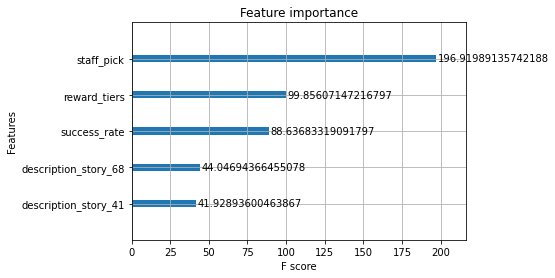

In [14]:
plot_importance(model_xgboost_fin, importance_type = 'gain', max_num_features=5)
plt.show()

In [15]:
var_colums = [c for c in X_train.columns if c not in ['state']]

df_var_imp = pd.DataFrame({"Feature": var_colums,
                           "Importance": model_xgboost_fin.feature_importances_})\
                        .sort_values(by='Importance', ascending=False)
df_var_imp[:10]

,Feature,Importance
4,staff_pick,0.049049
0,reward_tiers,0.024872
421,success_rate,0.022078
274,description_story_68,0.010971
247,description_story_41,0.010444
5,has_video,0.009733
300,description_story_94,0.009271
422,x0_art,0.008429
3,goal,0.008129
414,description_story_word_count,0.007118


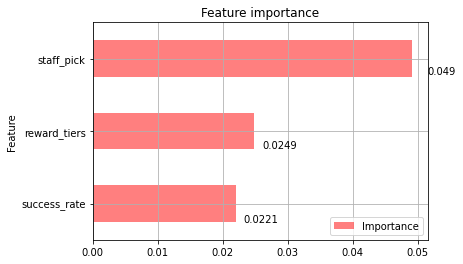

In [17]:
top_5_features = df_var_imp[:3].sort_values('Importance').set_index('Feature')
ax = top_5_features.plot.barh(color='red', alpha=0.5, grid=True, title='Feature importance', figsize=(6, 4))
for p, value in zip(ax.patches, top_5_features['Importance']):
    ax.annotate(round(value, 4), (p.get_width() * 1.05, p.get_y() * 1.02))

In [2]:
import pickle
with open('data/tfidf_feature_names.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)
print(loaded_dict['description_story'])

[(0, '2'), (1, 'able'), (2, 'album'), (3, 'also'), (4, 'around'), (5, 'art'), (6, 'artist'), (7, 'available'), (8, 'back'), (9, 'backer'), (10, 'best'), (11, 'book'), (12, 'bring'), (13, 'campaign'), (14, 'come'), (15, 'community'), (16, 'cost'), (17, 'create'), (18, 'day'), (19, 'de'), (20, 'design'), (21, 'different'), (22, 'en'), (23, 'even'), (24, 'every'), (25, 'experience'), (26, 'family'), (27, 'film'), (28, 'find'), (29, 'first'), (30, 'friend'), (31, 'fund'), (32, 'game'), (33, 'get'), (34, 'give'), (35, 'go'), (36, 'goal'), (37, 'great'), (38, 'ha'), (39, 'help'), (40, 'im'), (41, 'kickstarter'), (42, 'know'), (43, 'la'), (44, 'le'), (45, 'life'), (46, 'like'), (47, 'love'), (48, 'made'), (49, 'make'), (50, 'making'), (51, 'many'), (52, 'money'), (53, 'much'), (54, 'music'), (55, 'need'), (56, 'new'), (57, 'one'), (58, 'part'), (59, 'people'), (60, 'place'), (61, 'please'), (62, 'pledge'), (63, 'print'), (64, 'product'), (65, 'production'), (66, 'project'), (67, 'que'), (68, 